In [16]:
import math
import numpy as np
import scipy.integrate as integrate   # для решения ОДУ в методе DEM
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12) 

# Hashin–Shtrikman bounds (HS)

In [17]:
# HS - bulk модуль - 2 компоненты (prop - в процентах)
def get_HS_bulk_bounds(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для объемного модуля сжатия (bulk) композита,
    # состоящего из двух компонент

    # входные данные
    k1, k2 = bulk        # объемные модули сжатия (bulk) 1ой и 2ой компонент
    g1, g2 = shear       # модули сдвига (shear) 1ой и 2ой компонент
    f1 = prop / 100       # объмное содержание 1ой компоненты (f1 - в долях, prop - в %)
    f2 = 1 - prop / 100   # объемное содержание 2ой компоненты
    
    # случай 1
    if k1 == k2:
        return k

    # случай 2: (k1 > k2) and (g1 > g2) - компонента 1 более жесткая
    if ((k1 - k2) * (g1 - g2) > 0) or (g1 == g2):
        bulk_bounds = sorted([k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))])
    else:
        # случай 3.1: (k1 > k2) but (g1 < g2)
        if k1 > k2:
            if k1 + 0.5 / (1 / (k2 - k1) + 0.5 / (k1 + 4 * g1 / 3)) > k2 + 0.5 / (
                    1 / (k1 - k2) + 0.5 / (k2 + 4 * g2 / 3)):
                bulk_bounds = [k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3)),
                               k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3))]
            else:
                bulk_bounds = [k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))]
        # случай 3.2: (k1 < k2) but (g1 > g2)
        else:
            if k1 + 0.5 / (1 / (k2 - k1) + 0.5 / (k1 + 4 * g1 / 3)) > k2 + 0.5 / (
                    1 / (k1 - k2) + 0.5 / (k2 + 4 * g2 / 3)):
                bulk_bounds = [k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3)),
                               k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3))]
            else:
                bulk_bounds = [k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))]

    return bulk_bounds



# HS - shear модуль - 2 компоненты (prop - в процентах)
def get_HS_shear_bounds(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для модуля сдвига (shear) композита,
    # состоящего из двух компонент

    # входные данные
    k1, k2 = bulk  # объемные модули сжатия (bulk) 1ой и 2ой компонент
    g1, g2 = shear  # модули сдвига (shear) 1ой и 2ой компонент
    f1 = prop / 100  # объмное содержание 1ой компоненты (f1 - в долях, prop - в %)
    f2 = 1 - prop / 100  # объемное содержание 2ой компоненты

    # случай 1
    if g1 == g2:
        return shear

    # случай 2: (k1 > k2) and (g1 > g2) - компонента 1 более жесткая
    if ((k1 - k2) * (g1 - g2) > 0) or (k1 == k2):
        shear_bounds = sorted([g1 + f2 / (1 / (g2 - g1) + 2 * f1 * (k1 + 2 * g1) / (5 * g1 * (k1 + 4 * g1 / 3))),
                               g2 + f1 / (1 / (g1 - g2) + 2 * f2 * (k2 + 2 * g2) / (5 * g2 * (k2 + 4 * g2 / 3)))])
    else:
        if g1 > g2:
            if g2 + 0.5 / (1 / (g1 - g2) + 0.5 / (g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (
                    min(bulk) + 2 * min(shear))) / 6)) > g1 + 0.5 / (
                    1 / (g2 - g1) + 0.5 / (g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)):
                shear_bounds = [g1 + f2 / (1 / (g2 - g1) + f1 / (
                                    g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)),
                                g2 + f1 / (
                                        1 / (g1 - g2) + f2 / (
                                            g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6))]
            else:
                shear_bounds = [g2 + f1 / (
                    1 / (g1 - g2) + f2 / (g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)),
                            g1 + f2 / (1 / (g2 - g1) + f1 / (
                                    g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6))]
        else:
            if g2 + f1 / (1 / (g1 - g2) + f2 / (g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (
                    max(bulk) + 2 * max(shear))) / 6)) > g1 + f2 / (
                    1 / (g2 - g1) + f1 / (g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)):
                shear_bounds = [g1 + f2 / (
                        1 / (g2 - g1) + f1 / (g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)),
                                g2 + f1 / (1 / (g1 - g2) + f2 / (
                                        g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6))]
            else:
                shear_bounds = [g2 + f1 / (1 / (g1 - g2) + f2 / (
                                        g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)),
                                g1 + f2 / (1 / (g2 - g1) + f1 / (
                                        g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6))]

    return shear_bounds


# вспомогательная (prop - в процентах)
def get_proportion_for_HS(prop1, prop2):
    # функция является вспомогательной для нахождения границ HS для многих компонент,
    # на вход принимает процентное содержание двух компонент в составе многих и
    # пересчитывает их в предположении, что в сумме две компоненты дают 100%

    sum = prop1 + prop2
    final_prop = (prop1/sum)*100
    return final_prop



# HS - bulk и shear модули - много компонент (prop - в процентах)
def get_HS_for_many_components(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для bulk и shear модулей композита,
    # состоящего из N компонент

    # на вход подаются два массива, содержащие значения bulk и shear модулей N компонент
    # bulk = [k1, k2, ..., ki, ..., kn], shear = [g1, g2, ..., gi, ..., gn]
    # также подается массив prop, содержащий процентное содержание всех компонент в %

    N = len(bulk)
    if N >= 3:
        for _ in range(N - 2):

            # будем брать в каждом массиве по 2 последних элемента и считать их границы HS
            bulk_for_2 = [bulk[-1], bulk[-2]]
            shear_for_2 = [shear[-1], shear[-2]]
            prop_for_2 = get_proportion_for_HS(prop[-1], prop[-2])

            bulk_bounds = get_HS_bulk_bounds(bulk_for_2, shear_for_2, prop_for_2)
            shear_bounds = get_HS_shear_bounds(bulk_for_2, shear_for_2, prop_for_2)

            bulk[-2] = np.mean(bulk_bounds)
            shear[-2] = np.mean(shear_bounds)
            prop[-2] = prop[-1] + prop[-2]

            bulk.pop(-1)
            shear.pop(-1)
            prop.pop(-1)

            print(bulk)
            print(shear)
            print(prop)

        # когда остались только 2 компоненты, применяем к ним метод HS для двух компонент
        final_bulk_bounds = get_HS_bulk_bounds(bulk, shear, prop[0])
        final_shear_bounds = get_HS_shear_bounds(bulk, shear, prop[0])

    else:   # на случай, если с помощью этой функции хотят посчитать HS для 2х комонент
        final_bulk_bounds = get_HS_bulk_bounds(bulk, shear, prop)
        final_shear_bounds = get_HS_shear_bounds(bulk, shear, prop)

    return final_bulk_bounds, final_shear_bounds


# HS - bulk и shear модули - 2 компоненты - для всех пропорций
def get_HS_for_all_proportions(comp1, comp2, sampling_step = 100):
    # функция рассчитывает границы HS для всех отношений двух компонент
    # на вход принимаются значения упругих модулей и параметр дискретизации

    bulk = [comp1[0], comp2[0]]
    shear = [comp1[1], comp2[1]]

    proportion = []
    bulk_up = []
    bulk_down = []
    shear_up = []
    shear_down = []

    average_bulk = []
    average_shear = []

    for prop in range(sampling_step):
        proportion.append(prop/sampling_step)

        current_bulk = get_HS_bulk_bounds(bulk, shear, prop)
        current_shear = get_HS_shear_bounds(bulk, shear, prop)

        bulk_up.append(current_bulk[1])
        bulk_down.append(current_bulk[0])
        shear_up.append(current_bulk[1])
        shear_down.append(current_bulk[0])

        average_bulk.append((current_bulk[0] + current_bulk[1])/2)
        average_shear.append((current_shear[0] + current_shear[1]) / 2)

    return proportion, average_bulk, average_shear


# HS - bulk и shear модули смеси двух твердых компонент
def get_moduli_by_HS(get_HS_for_all_proportions, comp1, comp2, proportion):
    # proportion - содержание первой компоненты в %

    prop, average_bulk, average_shear = get_HS_for_all_proportions(comp1, comp2)

    index = prop.index(proportion/100)

    return [average_bulk[index], average_shear[index]]

# Self-Consistent Approximation (SCA) 

In [18]:
def get_all_values_by_SCA(pores, matrix, sampling_step = 100):
    # функция принимает на вход два массива следующего вида:
    # pores = [bulk_p, shear_p, asp_p], где элементы массива: bulk и shear модули и аспектное отношение флюида,
        # насыщающего поры (воздух, например)
    # matrix = [bulk_m, shear_m, asp_m]
    # porosity - пористость

    # возвращает bulk и shear модули композита матрица+поры

    k1, n1, asp1 = pores
    k2, n2, asp2 = matrix

    kbr = []
    nbr = []
    por = []

    # чтобы нигде не было деления на 0
    if asp1 == 1:
        asp1 = 0.99
    if asp2 == 1:
        asp2 = 0.99



    # вычислим theta и fn (через аспектное отношения), которые понадобятся для дальнейших рассчетов

    # asp < 1 - oblate spheroid (сплюснутый элипсоид)
    if asp1 < 1:
        theta1 = (asp1 / ((1 - asp1 ** 2) ** (3 / 2))) * (math.acos(asp1) - asp1 * math.sqrt(1 - asp1 ** 2))
        fn1 = (asp1 ** 2 / (1 - asp1 ** 2)) * (3 * theta1 - 2)

    if asp2 < 1:
        theta2 = (asp2 / ((1 - asp2 ** 2) ** (3 / 2))) * (math.acos(asp2) - asp2 * math.sqrt(1 - asp2 ** 2))
        fn2 = (asp2 ** 2 / (1 - asp2 ** 2)) * (3 * theta2 - 2)

    # asp > 1 - prolate spheroid (вытянутый элипсоид)
    if asp1 > 1:
        theta1 = (asp1 / ((asp1 ** 2 - 1) ** (3 / 2))) * (asp1 * math.sqrt(asp1 ** 2 - 1) - math.acosh(asp1))
        fn1 = (asp1 ** 2 / (asp1 ** 2 - 1)) * (2 - 3 * theta1)

    if asp2 > 1:
        theta2 = (asp2 / ((asp2 ** 2 - 1) ** (3 / 2))) * (asp2 * math.sqrt(asp2 ** 2 - 1) - math.acosh(asp2))
        fn2 = (asp2 ** 2 / (asp2 ** 2 - 1)) * (2 - 3 * theta2)

    epsilon = 1e-7   # опять же, чтобы нигде не было деления на ноль

    if k1 == 0:
        k1 = 1e-3
    if k2 == 0:
        k2 = 1e-3
    if n1 == 0:
        n1 = 1e-3
    if n2 == 0:
        n2 = 1e-3

    # пройдем по всем значениям пористости от 0 до 100%
    # x1 - пористость, x2 - содержание твердой компоненты
    for x1 in [epsilon] + [i /sampling_step for i in range(1, sampling_step)] + [0.5 - epsilon]:
        x2 = 1 - x1

        ksc = x1 * k1 + x2 * k2
        nsc = x1 * n1 + x2 * n2
        knew = 0
        nnew = 0
        tol = 1e-6 * k1
        d = abs(ksc - knew)
        niter = 0

        if nsc == 0:
            pass

        while (d > abs(tol)) and (niter < 3000):
            nusc = (3 * ksc - 2 * nsc) / (2 * (3 * ksc + nsc))
            a1 = n1 / nsc - 1
            a2 = n2 / nsc - 1
            b1 = (1 / 3) * (k1 / ksc - n1 / nsc)
            b2 = (1 / 3) * (k2 / ksc - n2 / nsc)
            r = (1 - 2 * nusc) / (2 * (1 - nusc))

            f11 = 1 + a1 * ((3 / 2) * (fn1 + theta1) - r * ((3 / 2) * fn1 + (5 / 2) * theta1 - (4 / 3)))
            f12 = 1 + a2 * ((3 / 2) * (fn2 + theta2) - r * ((3 / 2) * fn2 + (5 / 2) * theta2 - (4 / 3)))

            f21 = 1 + a1 * (1 + (3 / 2) * (fn1 + theta1) - (r / 2) * (3 * fn1 + 5 * theta1)) + b1 * (3 - 4 * r)
            f21 = f21 + (a1 / 2) * (a1 + 3 * b1) * (3 - 4 * r) * (fn1 + theta1 - r * (fn1 - theta1 + 2 * theta1 ** 2))
            f22 = 1 + a2 * (1 + (3 / 2) * (fn2 + theta2) - (r / 2) * (3 * fn2 + 5 * theta2)) + b2 * (3 - 4 * r)
            f22 = f22 + (a2 / 2) * (a2 + 3 * b2) * (3 - 4 * r) * (fn2 + theta2 - r * (fn2 - theta2 + 2 * theta2 ** 2))

            f31 = 1 + a1 * (1 - (fn1 + (3 / 2) * theta1) + r * (fn1 + theta1))
            f32 = 1 + a2 * (1 - (fn2 + (3 / 2) * theta2) + r * (fn2 + theta2))

            f41 = 1 + (a1 / 4) * (fn1 + 3 * theta1 - r * (fn1 - theta1))
            f42 = 1 + (a2 / 4) * (fn2 + 3 * theta2 - r * (fn2 - theta2))

            f51 = a1 * (-fn1 + r * (fn1 + theta1 - (4 / 3))) + b1 * theta1 * (3 - 4 * r)
            f52 = a2 * (-fn2 + r * (fn2 + theta2 - (4 / 3))) + b2 * theta2 * (3 - 4 * r)

            f61 = 1 + a1 * (1 + fn1 - r * (fn1 + theta1)) + b1 * (1 - theta1) * (3 - 4 * r)
            f62 = 1 + a2 * (1 + fn2 - r * (fn2 + theta2)) + b2 * (1 - theta2) * (3 - 4 * r)

            f71 = 2 + (a1 / 4) * (3 * fn1 + 9 * theta1 - r * (3 * fn1 + 5 * theta1)) + b1 * theta1 * (3 - 4 * r)
            f72 = 2 + (a2 / 4) * (3 * fn2 + 9 * theta2 - r * (3 * fn2 + 5 * theta2)) + b2 * theta2 * (3 - 4 * r)

            f81 = a1 * (1 - 2 * r + (fn1 / 2) * (r - 1) + (theta1 / 2) * (5 * r - 3)) + b1 * (1 - theta1) * (3 - 4 * r)
            f82 = a2 * (1 - 2 * r + (fn2 / 2) * (r - 1) + (theta2 / 2) * (5 * r - 3)) + b2 * (1 - theta2) * (3 - 4 * r)

            f91 = a1 * ((r - 1) * fn1 - r * theta1) + b1 * theta1 * (3 - 4 * r)
            f92 = a2 * ((r - 1) * fn2 - r * theta2) + b2 * theta2 * (3 - 4 * r)

            p1 = 3 * f11 / f21
            p2 = 3 * f12 / f22
            q1 = (2 / f31) + (1 / f41) + ((f41 * f51 + f61 * f71 - f81 * f91) / (f21 * f41))
            q2 = (2 / f32) + (1 / f42) + ((f42 * f52 + f62 * f72 - f82 * f92) / (f22 * f42))

            p1 = p1 / 3
            p2 = p2 / 3
            q1 = q1 / 5
            q2 = q2 / 5

            knew = (x1 * k1 * p1 + x2 * k2 * p2) / (x1 * p1 + x2 * p2)
            nnew = (x1 * n1 * q1 + x2 * n2 * q2) / (x1 * q1 + x2 * q2)

            d = abs(ksc - knew)
            ksc = knew
            nsc = nnew
            niter = niter + 1

        por.append(x1)   # массив со значениями пористости
        kbr.append(ksc)
        nbr.append(nsc)

    return por, kbr, nbr


def get_moduli_by_SCA(get_all_values_by_SCA, pores, matrix, porosity):
    por, kbr, nbr = get_all_values_by_SCA(pores, matrix)

    index = por.index(round(porosity / 100, 2))

    return [kbr[index], nbr[index]]

# DIfferential Effective Medium (DEM) 

In [19]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def theta(alpha):
    return alpha*(np.arccos(alpha) - alpha*np.sqrt(1.0 - alpha*alpha))/(1.0 - alpha*alpha)**(3.0/2.0)

def f(alpha, theta):
    return alpha*alpha*(3.0*theta - 2.0)/(1.0 - alpha*alpha)

def PQ(A, B, R, theta, f):
    F1 = 1.0 + A*(1.5*(f + theta) - R*(1.5*f + 2.5*theta - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + theta) - R*(1.5*f + 2.5*theta)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + theta - R*(f - theta + 2.0*theta*theta))
    F3 = 1.0 + A*(1.0 - f - 1.5*theta + R*(f + theta))
    F4 = 1.0 + (A/4.0)*(f + 3.0*theta - R*(f - theta))
    F5 = A*(-f + R*(f + theta - 4.0/3.0)) + B*theta*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + theta)) + B*(1.0 - theta)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*theta - R*(3.0*f + 5.0*theta)) + B*theta*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (theta/2.0)*(5.0*R - 3.0)) + B*(1.0 - theta)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*theta) + B*theta*(3.0 - 4.0*R)
    
    P = 3.0*F1/F2
    Q = 2.0/F3 + 1.0/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    return P, Q

def KG(Km, Gm, Ki, Gi, ci, theta, f):
    A = Gi/Gm - 1.0
    B = (Ki/Km - Gi/Gm)/3.0
    R = Gm/(Km + (4.0/3.0)*Gm)
    Fm = (Gm/6.0)*(9.0*Km + 8.0*Gm)/(Km + 2.0*Gm)
    
    P, Q = PQ(A, B, R, theta, f)

    K = Km - (Km + (4.0/3.0)*Gm)*ci*(Km - Ki)*P/3.0/(Km + (4.0/3.0)*Gm + ci*(Km - Ki)*P/3.0)
    G = Gm - (Gm + Fm)*ci*(Gm - Gi)*Q/5.0/(Gm + Fm + ci*(Gm - Gi)*Q/5.0)
    
    return K, G

def DEM(Km, Gm, Ki, Gi, alphai, phii, phi0=0.0, r=1000, phitol=1.0E-10, gamma=0.01):
    phi = np.sum(phii)
    fraci = phii/np.sum(phi)
    ci = fraci*alphai/r
    n = int(np.ceil((np.log(1.0-phi)-np.log(1.0-phi0))/np.sum(np.log(1.0-ci))))
    m = len(alphai)
    
    def func(r):
        f = np.empty(m)
        f[0] = np.log(alphai[0]/r[0]) + np.log(1.0 - phi0/phi) - np.log(1 - ((1.0 - phi)/(1.0 - phi0))**(1.0/n))
        for j in range(1, m):
            f[j] = f[j-1] + np.log(alphai[j]/r[j]) + np.log(r[j-1]/alphai[j-1] - fraci[j-1])
        return f
    
    def fprime(r):
        jac = np.diag(-1.0/r)
        for j in range(0, m-1):
            jac[j+1:, j] = -1.0/r[j] + 1.0/(r[j] - fraci[j]*alphai[j])
        
        return jac
    
    r0 = r*np.ones(m)
    
    ri = fsolve(func, r0, fprime=fprime, factor=0.1)
    
    ci = fraci*alphai/ri
    
    thetai = theta(alphai)
    fi = f(alphai, thetai)
    
    K = np.empty(n)
    G = np.empty(n)
    phi = np.empty(n)

    K_ = Km
    G_ = Gm
    phi_ = phi0
    
    for i in range(n):
        dphi = ci[0]*(1.0 - phi_)
        K_, G_ = KG(K_, G_, Ki[0], Gi[0], ci[0], thetai[0], fi[0])
        phi_ += dphi
        for j in range(1, m):
            dphi *= ci[j]*(1.0 - ci[j-1])/ci[j-1]
            K_, G_ = KG(K_, G_, Ki[j], Gi[j], ci[j], thetai[j], fi[j])
            phi_ += dphi
        K[i] = K_
        G[i] = G_
        phi[i] = phi_
    
    return K, G, phi


def Ks(Kd, Km, Kf, phi):
    gamma = 1.0 - phi - Kd/Km
    return Kd + (gamma + phi)**2/(gamma/Km + phi/Kf)


def Kd(Ks, Km, Kf, phi):
    gamma = phi*(Km/Kf - 1.0)
    return (Ks*(gamma + 1.0) - Km)/(gamma - 1.0 + Ks/Km)

In [20]:
def get_DEM_aspect_moduli(matrix, fluid, porosity, aspect_ratio, DEM):
    
    Km = matrix[0] # GPa
    Gm = matrix[1] # GPa
    rhom = matrix[2] # g/cm3
    
    Kf = fluid[0] # GPa
    rhof = fluid[2] # g/cm3
    
    # Porosity
    phimax = porosity/100
    
    alphas = np.array([aspect_ratio])
    volumes = np.array([1])*phimax
    
    # Dry inclusions
    Kis = np.zeros(len(alphas), dtype=float)
    Gis = np.zeros(len(alphas), dtype=float)
    
    K, G, phi = DEM(Km, Gm, Kis, Gis, alphas, volumes)
    
    return [K[-1], G[-1]]

# Wood & Gassmann Formulas

In [21]:
# bulk модуль смеси флюидов по формуле Вуда (prop - в процентах)
def get_fluid_modulus_by_wood(fluid1, fluid2, prop):
    # функция принимает на вход объемные модули сжатия и объемное содержание всех флюидов,
    # входящих в поронасыщающую смесь, и возвращает модуль сжатия смеси (модуль сдвига флюида всегда = 0)

    bulk = [fluid1[0], fluid2[0]]
    average_shear = 0

    if bulk[0] == 0:
        bulk[0] = 1e-7
    if bulk[1] == 0:
        bulk[1] = 1e-7

    bulk = np.array(bulk)
    prop = np.array(prop)

    new_prop = prop / 100   # объемные отношения в долях единицы
    divided_bulk = np.sum(new_prop / bulk)
    average_bulk = 1 / divided_bulk   # объемный модуль сжатия смеси флюидов

    return [average_bulk, average_shear]


# формула Гассмана - получаем упругие модули породы, поры которой насыщены флюидом
def get_saturated_by_gassman(dry, matrix, fluid, porosity):
    k_dry, g_dry = dry  # сухая порода
    k_m, g_m = matrix  # твердое вещество (без пор)
    k_fl, g_fl = fluid  # флюид
    
    if k_fl == 0:
        k_fl = 0.00001
    if g_fl == 0:
        g_fl = 0.00001

    g_sat = g_dry

    k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)

    return [k_sat, g_sat]


# рассчет скоростей vp и vs
def get_velocity(rho, saturated):
    k, g = saturated[0], saturated[1]

    vp = math.sqrt((k + g * 4 / 3) / rho)
    vs = math.sqrt(g / rho)
    return vp, vs

# Задача

In [61]:
# создадим данные

# список со значениями пористости
#porosity = np.around(np.random.normal(loc = 15, scale = 5, size = 100), decimals = 0)
quarz_list = []

# список со значениями аспектного отношения
#aspect_ratio = np.random.normal(loc = 0.4, scale = 0.05, size = 100)

#for i in range(len(porosity)):
    #if porosity[i] < 0:
        #porosity[i] = 15
    #quarz_list.append(100 - porosity[i])
    
    #if aspect_ratio[i] <= 0:
        #aspect_ratio[i] = 0.4
    

#porosity = np.ndarray.tolist(porosity)
#aspect_ratio = np.ndarray.tolist(aspect_ratio)

porosity = [18.0, 14.0, 13.0, 12.0, 16.0, 25.0, 16.0, 15.0, 20.0, 11.0, 4.0, 16.0, 11.0, 13.0, 9.0, 5.0, 15.0, 15.0, 11.0, 16.0, 20.0, 12.0, 16.0, 17.0, 7.0, 14.0, 18.0, 18.0, 21.0, 14.0, 20.0, 10.0, 3.0, 11.0, 16.0, 26.0, 16.0, 16.0, 15.0, 12.0, 13.0, 23.0, 13.0, 13.0, 11.0, 23.0, 25.0, 11.0, 15.0, 14.0, 5.0, 6.0, 9.0, 15.0, 3.0, 18.0, 15.0, 18.0, 11.0, 20.0, 14.0, 17.0, 16.0, 13.0, 18.0, 15.0, 16.0, 17.0, 2.0, 10.0, 7.0, 11.0, 8.0, 12.0, 10.0, 12.0, 15.0, 13.0, 9.0, 12.0, 12.0, 15.0, 20.0, 15.0, 15.0, 12.0, 13.0, 17.0, 17.0, 15.0, 17.0, 20.0, 19.0, 5.0, 19.0, 10.0, 8.0, 18.0, 25.0, 12.0]
aspect_ratio = [0.4576559448543612, 0.33032029706346966, 0.4285808711051951, 0.3786401101079888, 0.33036454240320867, 0.42467441251384225, 0.4252084135446623, 0.37902241182129165, 0.33992727485646124, 0.403881271630413, 0.4325941500943883, 0.5172402575686441, 0.502973882536929, 0.44358921473263613, 0.4185740166847349, 0.3557136947312507, 0.4388568633087236, 0.363555966624358, 0.33268233983054, 0.41102908140090716, 0.36843192611939773, 0.4009950072861589, 0.523598697019354, 0.3855456842263613, 0.35512087985696666, 0.371776151150397, 0.4316263631351388, 0.41191467839649293, 0.3865843089986145, 0.4092762248801046, 0.39645814956024467, 0.3841283717997894, 0.39955562501368375, 0.44498169917712743, 0.3634334658350868, 0.2939156423115344, 0.3687743474175714, 0.4152782834236491, 0.4612146128781255, 0.40558427575470724, 0.2942523159040927, 0.47994328015837934, 0.35296928534001903, 0.35362520169874445, 0.3821008959160917, 0.44191575630183644, 0.3493534991672843, 0.40741154447126604, 0.3967092060740421, 0.45927703650018603, 0.3524219561944225, 0.4231883865964186, 0.4019381024491527, 0.3620452911274871, 0.39337497096016427, 0.4393024539510615, 0.4439134560626507, 0.4303719693907973, 0.3826761615969525, 0.4030388769451286, 0.39036430611357426, 0.35003055000800143, 0.3423631840855345, 0.4303434961016194, 0.37830801156094573, 0.4404701141760211, 0.3760384707682245, 0.44682934766417526, 0.42804273208241694, 0.40245831963762685, 0.37606635323210497, 0.443568571675985, 0.384278446489419, 0.4742880716069164, 0.35858854270535345, 0.4144622939030285, 0.4340282398767819, 0.47186071345704955, 0.41857411621420126, 0.43398909248863216, 0.3709644203685405, 0.3846055671100541, 0.3896661419434561, 0.47704538249614636, 0.4054426685279916, 0.3991405321536832, 0.3981977720931961, 0.41434292108311016, 0.3709929779668878, 0.46029971987277096, 0.34546989546975093, 0.39263482576424863, 0.4337202848006103, 0.4376418938605534, 0.324225953827102, 0.45314379958688356, 0.3907884642295216, 0.46139188946009324, 0.4022371685760636, 0.40684160653809354]

for i in range(len(porosity)):
    quarz_list.append(100 - porosity[i])

print(porosity)
#print(min(porosity))
#print(max(porosity))
#print(sum(porosity)/len(porosity))
print()
print(quarz_list)
print()
print(aspect_ratio)

depth = np.arange(3000, 3000 + len(porosity), 1)

[18.0, 14.0, 13.0, 12.0, 16.0, 25.0, 16.0, 15.0, 20.0, 11.0, 4.0, 16.0, 11.0, 13.0, 9.0, 5.0, 15.0, 15.0, 11.0, 16.0, 20.0, 12.0, 16.0, 17.0, 7.0, 14.0, 18.0, 18.0, 21.0, 14.0, 20.0, 10.0, 3.0, 11.0, 16.0, 26.0, 16.0, 16.0, 15.0, 12.0, 13.0, 23.0, 13.0, 13.0, 11.0, 23.0, 25.0, 11.0, 15.0, 14.0, 5.0, 6.0, 9.0, 15.0, 3.0, 18.0, 15.0, 18.0, 11.0, 20.0, 14.0, 17.0, 16.0, 13.0, 18.0, 15.0, 16.0, 17.0, 2.0, 10.0, 7.0, 11.0, 8.0, 12.0, 10.0, 12.0, 15.0, 13.0, 9.0, 12.0, 12.0, 15.0, 20.0, 15.0, 15.0, 12.0, 13.0, 17.0, 17.0, 15.0, 17.0, 20.0, 19.0, 5.0, 19.0, 10.0, 8.0, 18.0, 25.0, 12.0]

[82.0, 86.0, 87.0, 88.0, 84.0, 75.0, 84.0, 85.0, 80.0, 89.0, 96.0, 84.0, 89.0, 87.0, 91.0, 95.0, 85.0, 85.0, 89.0, 84.0, 80.0, 88.0, 84.0, 83.0, 93.0, 86.0, 82.0, 82.0, 79.0, 86.0, 80.0, 90.0, 97.0, 89.0, 84.0, 74.0, 84.0, 84.0, 85.0, 88.0, 87.0, 77.0, 87.0, 87.0, 89.0, 77.0, 75.0, 89.0, 85.0, 86.0, 95.0, 94.0, 91.0, 85.0, 97.0, 82.0, 85.0, 82.0, 89.0, 80.0, 86.0, 83.0, 84.0, 87.0, 82.0, 85.0, 84.0, 83.0, 98.0

In [62]:
print(len(quarz_list))
print(len(depth))
print(len(aspect_ratio))

100
100
100


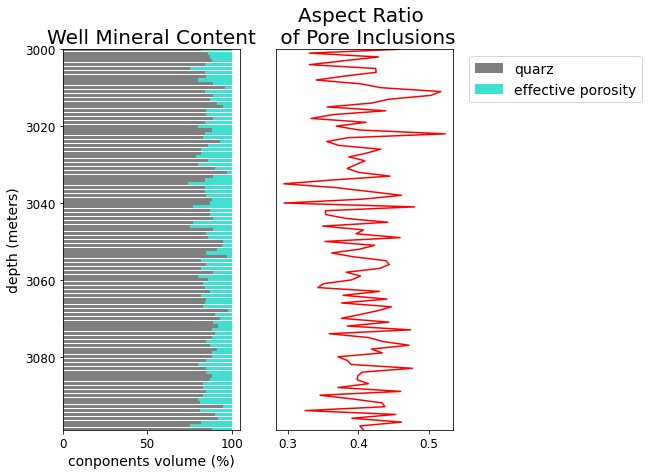

In [63]:
# нарисуем скважину

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

turquoise = '#40E0D0'
dark_violet = '#9932CC'
violet = '#EE82EE'
spring_green = '#00FF7F'

axes[0].set_title('Well Mineral Content', fontsize = 20)
axes[0].barh(depth, quarz_list, color = 'grey')
axes[0].barh(depth, porosity, color = turquoise, left = quarz_list)
axes[0].set_xlabel('conponents volume (%)', fontsize = 14)
axes[0].set_ylabel('depth (meters)', fontsize = 14)
axes[0].set_ylim(max(depth), min(depth))
axes[0].legend(['quarz', 'effective porosity'], fontsize = 14,
          bbox_to_anchor=(3.3, 1))


axes[1].plot(aspect_ratio, depth, c = 'r', linewidth = 1.5)
axes[1].set_title('Aspect Ratio \n of Pore Inclusions', fontsize = 20)
axes[1].yaxis.set_visible(False)
axes[1].set_ylim(max(depth), min(depth))

plt.show()

In [64]:
# упругие модули и плотность
quarz_moduli = [70.8, 30.3, 2.71]
gas = [2.496, 0, 1]

# Решение

## Прямая задача 

In [65]:
def do_forward_problem(get_DEM_aspect_moduli, get_velocity, porosity, aspect_ratio, quarz_moduli = [70.8, 30.3, 2.71], 
                       gas = [2.496, 0, 1]):
    
    # кварц + поры по SCA
    moduli = get_DEM_aspect_moduli(quarz_moduli, gas, porosity, aspect_ratio, DEM)

    # рассчитаем скорости Vp и Vs
    
    rho_final = gas[2] * porosity/100 + quarz_moduli[2] * (100 - porosity) / 100

    vp, vs = get_velocity(rho_final, moduli)

    return vp, vs, moduli

In [70]:
def get_velocities_in_well(do_forward_problem, porosity, aspect_ratio):
    
    well_vp = []
    well_vs = []
    moduli = []
    
    for i in range(len(porosity)):
        por = porosity[i]
        aspect = aspect_ratio[i]
        
        vp_sample, vs_sample, moduli_sample = do_forward_problem(get_DEM_aspect_moduli, get_velocity, por, aspect)
        well_vp.append(vp_sample)
        well_vs.append(vs_sample)
        moduli.append(moduli_sample)
    
    return well_vp, well_vs, moduli

# находит значения плотности в скважине
def get_rho(por, rho = [quarz_moduli[2], gas[2]]):
    final_rho = []
    for i in range(len(por)):
        final_rho.append(rho[1] * por[i]/100 + rho[0] * (100 - por[i]) / 100)
    return final_rho

In [67]:
# решим прямую задачу для исходных данных
all_vp, all_vs, moduli = get_velocities_in_well(do_forward_problem, porosity, aspect_ratio)

print(moduli)
print()
print(all_vp)
print()
print(all_vs)

well_vp = np.array(all_vp)
well_vs = np.array(all_vs)

[[38.822099302030104, 20.061356631413496], [41.15810173255352, 21.459764082022765], [45.5494153244884, 22.5971532865661], [46.00634029106285, 22.928002179475552], [38.03746510490273, 20.32236218493479], [29.470439613307448, 16.432833123898185], [40.92854304215507, 20.95683583168368], [41.21552720151243, 21.244050765334006], [32.80297278485212, 18.239758400655603], [48.31047589640062, 23.617693198034605], [61.96558666024427, 27.822523710881278], [42.58058517337342, 21.30073961459528], [49.957260194612964, 23.924589058677626], [45.846265973633955, 22.655406575525745], [52.107245965331636, 24.822484882463552], [58.86732316047619, 27.04833506950056], [42.69454502713254, 21.55312630731461], [40.742813082106224, 21.142991615635], [46.36280034356954, 23.241864271066024], [40.5894991451851, 20.8847306375585], [33.834302906774504, 18.494070794905415], [46.56336676196914, 23.036868518064995], [42.66641042577866, 21.318306979127307], [38.45887998981837, 20.199129765978164], [54.64961243810353, 25

In [72]:
# рассчитаем плотность по скважине

rho_list = get_rho(porosity, rho = [quarz_moduli[2], gas[2]])
print(rho_list)

[2.4022, 2.4706, 2.4877, 2.5048, 2.4364, 2.2825, 2.4364, 2.4535, 2.3680000000000003, 2.5219, 2.6415999999999995, 2.4364, 2.5219, 2.4877, 2.5561, 2.6245, 2.4535, 2.4535, 2.5219, 2.4364, 2.3680000000000003, 2.5048, 2.4364, 2.4193, 2.5903, 2.4706, 2.4022, 2.4022, 2.3509, 2.4706, 2.3680000000000003, 2.539, 2.6587, 2.5219, 2.4364, 2.2653999999999996, 2.4364, 2.4364, 2.4535, 2.5048, 2.4877, 2.3167, 2.4877, 2.4877, 2.5219, 2.3167, 2.2825, 2.5219, 2.4535, 2.4706, 2.6245, 2.6074, 2.5561, 2.4535, 2.6587, 2.4022, 2.4535, 2.4022, 2.5219, 2.3680000000000003, 2.4706, 2.4193, 2.4364, 2.4877, 2.4022, 2.4535, 2.4364, 2.4193, 2.6757999999999997, 2.539, 2.5903, 2.5219, 2.5732, 2.5048, 2.539, 2.5048, 2.4535, 2.4877, 2.5561, 2.5048, 2.5048, 2.4535, 2.3680000000000003, 2.4535, 2.4535, 2.5048, 2.4877, 2.4193, 2.4193, 2.4535, 2.4193, 2.3680000000000003, 2.3851, 2.6245, 2.3851, 2.539, 2.5732, 2.4022, 2.2825, 2.5048]


C:\Users\vdvor\AppData\Local\Temp\ipykernel_5392\2674982973.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


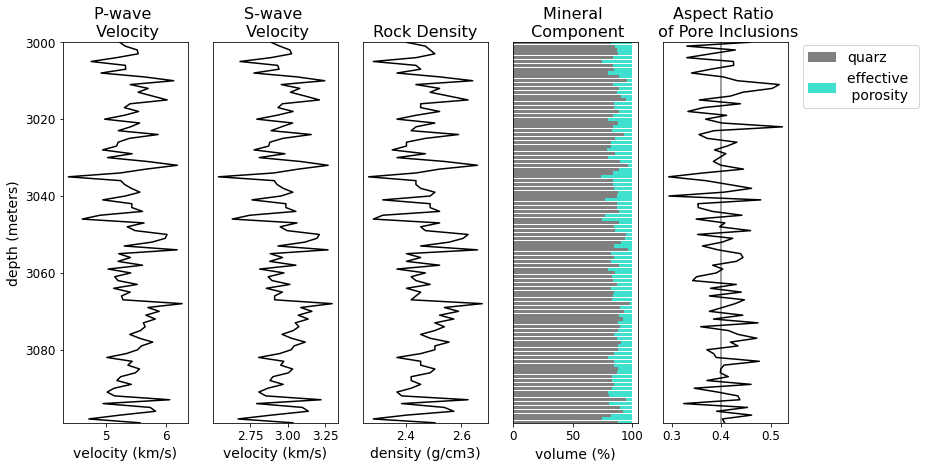

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(13, 7))

axes[3].barh(depth, quarz_list, color = 'grey')
axes[3].barh(depth, porosity, color = turquoise, left = quarz_list)
axes[3].set_xlabel('conponents volume (%)', fontsize = 14)
axes[3].set_ylim(bottom = max(depth), top = min(depth))
axes[3].legend(['quarz', 'effective \n porosity'], fontsize = 14, bbox_to_anchor=(3.3, 1.01))
axes[3].yaxis.set_visible(False)
axes[3].set_title('Mineral \n Component', fontsize = 16)
axes[3].set_xlabel('volume (%)', fontsize = 14)

axes[0].plot(well_vp, depth, c = 'k')
axes[0].set_ylim(bottom = max(depth), top = min(depth))
axes[0].set_title('P-wave \n Velocity', fontsize = 16)
axes[0].set_xlabel('velocity (km/s)', fontsize = 14)
axes[0].set_ylabel('depth (meters)', fontsize = 14)

axes[1].plot(well_vs, depth, c = 'k')
axes[1].set_ylim(bottom = max(depth), top = min(depth))
axes[1].yaxis.set_visible(False)
axes[1].set_title('S-wave \n Velocity', fontsize = 16)
axes[1].set_xlabel('velocity (km/s)', fontsize = 14)

aspect_mead = [0.4 for i in range(100)]
axes[4].plot(aspect_mead, depth, c = 'grey')
axes[4].plot(aspect_ratio, depth, c = 'k', linewidth = 1.5)
axes[4].set_title('Aspect Ratio \n of Pore Inclusions', fontsize = 16)
axes[4].yaxis.set_visible(False)
axes[4].set_ylim(max(depth), min(depth))

axes[2].plot(rho_list, depth, c = 'k')
axes[2].set_ylim(bottom = max(depth), top = min(depth))
axes[2].set_title('Rock Density', fontsize = 16)
axes[2].set_xlabel('density (g/cm3)', fontsize = 14)
axes[2].yaxis.set_visible(False)

fig.tight_layout()

# Обратная задача

## Монте-Карло 

In [79]:
# вычисляет невязку между исходными и инвертированными значениями скорости,
# на вход подаются исходные (vp_true, vs_true) и инвертированные (vp_sample, vs_sample) значения скорости (type = float),
# а также заранее заданная ошибка allowable error (float)

def check_how_close(vp_true, vs_true, vp_sample, vs_sample, allowable_error):
    error = math.sqrt((vp_true - vp_sample)**2 + (vs_true - vs_sample)**2)
    
    # если невязка удовлетворяет заранее заданному значения (allowable_error), функция возвращает True, иначе False
    if error < allowable_error:
        return True
    else:
        return False

In [80]:
# реализует метод Монте-Карло
# на вход подается функция для вычисления прямой задачи do_forward_problem, истинные значения скорости (vp_true, vs_true;
# type = float), N - количество настрелов (type - int), allowable_error - допустимая ошибка (type = float)

def do_monte_carlo(do_forward_problem, vp_true, vs_true, N, allowable_error, 
                   loc_por = 15, scale_por = 5, loc_aspect = 0.4, scale_aspect = 0.1):
    
    # создаются пустые массивы, которые будут заполняться инвертированными данными
    vs = []
    vp = []
    good_por = []
    good_aspect = []
    
    while len(good_por) < N:
        # настреливаются значения пористости по нормальному закону распределения
        por = np.random.normal(loc = loc_por, scale = scale_por)
        
        # настреливаются значения аспектного отношения пор
        aspect = np.random.normal(loc = loc_aspect, scale = scale_aspect)
        
        # убираются значения пористости и аспектного отношения, которые меньше или равны нулю
        if por <= 0:
            por = loc_por
        if aspect <= 0:
            aspect = loc_aspect

        vp_sample, vs_sample, moduli_sample = do_forward_problem(get_DEM_aspect_moduli, get_velocity, 
                                                                 por, aspect)
        check = check_how_close(vp_true, vs_true, vp_sample, vs_sample, allowable_error)
        
        if check == True:
            vp.append(vp_sample)
            vs.append(vs_sample)
            good_por.append(por)
            good_aspect.append(aspect)
    
    avg_por = sum(good_por) / len(good_por)
    avg_aspect = sum(good_aspect) / len(good_aspect)
    avg_vp = sum(vp) / len(vp)
    avg_vs = sum(vs) / len(vs)

    return avg_por, avg_aspect, avg_vp, avg_vs

In [86]:
from time import time

def do_inverse_problem(do_monte_carlo, well_vp, well_vs, N = 10, allowable_error = 0.1,
                       loc_por = 15, scale_por = 5, loc_aspect = 0.4, scale_aspect = 0.1,
                       file_name = 'quarz_well(1)_RESULTS.txt'):
    
    all_por = []
    all_aspect = []
    
    start = time()
    for i in range(len(well_vp)):
        
        print('отсчет', i)
        
        vp_true = well_vp[i]
        vs_true = well_vs[i]
        
        avg_por, avg_aspect, avg_vp, avg_vs = do_monte_carlo(do_forward_problem, vp_true, vs_true, N, allowable_error)
        
        all_por.append(avg_por)
        all_aspect.append(avg_aspect)
        
    end = time()
    
    # запишем результаты в файл
    
        #f_in.write('loc_por = {0} \n'.format(str(loc_por)))
        #f_in.write('scale_por = {0} \n'.format(str(scale_por)))
        #f_in.write('loc_aspect = {0} \n'.format(str(loc_aspect)))
        #f_in.write('scale_aspect = {0} \n'.format(str(scale_aspect)))
        #f_in.write('N = {0} \n'.format(str(N)))
        #f_in.write('allowable_error = {0} \n'.format(str(allowable_error)))
        #f_in.write('time(s) = {0} \n'.format(str(time)))
        #f_in.write(all_por, '\n')
        #f_in.write(all_aspect, '\n \n \n \n')
        
    file_object = open(file_name, 'a')
    file_object.write('loc_por = {0} \n'.format(str(loc_por)))
    file_object.close()
    
    return(all_por, all_aspect, end - start)

In [87]:
all_por, all_aspect, time = do_inverse_problem(do_monte_carlo, well_vp, well_vs, N = 1, allowable_error = 0.15)

отсчет 0
отсчет 1
отсчет 2
отсчет 3
отсчет 4
отсчет 5
отсчет 6
отсчет 7
отсчет 8
отсчет 9
отсчет 10
отсчет 11
отсчет 12
отсчет 13
отсчет 14
отсчет 15
отсчет 16
отсчет 17
отсчет 18
отсчет 19
отсчет 20
отсчет 21
отсчет 22
отсчет 23
отсчет 24
отсчет 25
отсчет 26
отсчет 27
отсчет 28
отсчет 29
отсчет 30
отсчет 31
отсчет 32
отсчет 33
отсчет 34
отсчет 35
отсчет 36
отсчет 37
отсчет 38
отсчет 39
отсчет 40
отсчет 41
отсчет 42
отсчет 43
отсчет 44
отсчет 45
отсчет 46
отсчет 47
отсчет 48
отсчет 49
отсчет 50
отсчет 51
отсчет 52
отсчет 53
отсчет 54
отсчет 55
отсчет 56
отсчет 57
отсчет 58
отсчет 59
отсчет 60
отсчет 61
отсчет 62
отсчет 63
отсчет 64
отсчет 65
отсчет 66
отсчет 67
отсчет 68
отсчет 69
отсчет 70
отсчет 71
отсчет 72
отсчет 73
отсчет 74
отсчет 75
отсчет 76
отсчет 77
отсчет 78
отсчет 79
отсчет 80
отсчет 81
отсчет 82
отсчет 83
отсчет 84
отсчет 85
отсчет 86
отсчет 87
отсчет 88
отсчет 89
отсчет 90
отсчет 91
отсчет 92
отсчет 93
отсчет 94
отсчет 95
отсчет 96
отсчет 97
отсчет 98
отсчет 99


In [84]:
print(all_por)
print()
print(all_aspect)

[18.097190944441863, 16.81474181636234, 15.67845822140064, 11.139695984270055, 16.079734049419393, 21.89387688635927, 16.47495869568309, 16.465113645120038, 21.007806846736894, 10.037782998381825, 2.9264567560179593, 13.157929566726487, 10.603721229305751, 10.16782926098822, 8.512948249431243, 6.720911699967111, 16.322034222741387, 14.12775767914122, 10.340912325390995, 18.927737972258925, 17.7552244076494, 13.770526570827931, 13.26787662988766, 16.569263703894666, 7.480626794195514, 14.597589638449712, 14.750624205850688, 16.865658860973628, 20.65998305124395, 11.878747039948028, 14.758515193420191, 11.011024547190285, 3.581845603537273, 9.810143120136296, 17.202406732462855, 21.320367322330583, 16.983619007038207, 15.717415394898689, 11.116046417785501, 9.354339074412078, 16.01245346201172, 18.76445490737014, 15.248025116972627, 14.350682084751755, 9.352889729304774, 18.28462500760588, 26.578227151165546, 13.015246696021418, 16.846231609923596, 15.353258449133083, 7.4731349532152445,

In [85]:
# решим прямую задачу для ИНВЕРТИРОВАННЫХ данных
all_vp_inverse, all_vs_inverse, moduli_inverse = get_velocities_in_well(do_forward_problem, all_por, all_aspect)

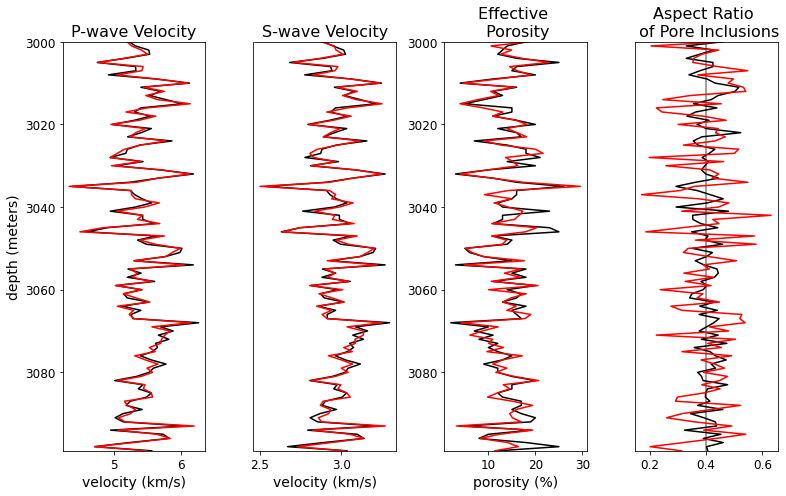

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(11, 7))

axes[0].plot(well_vp, depth, c = 'k')
axes[0].plot(all_vp_inverse, depth, c = 'r')
axes[0].set_ylim(bottom = max(depth), top = min(depth))
axes[0].set_title('P-wave Velocity', fontsize = 16)
axes[0].set_xlabel('velocity (km/s)', fontsize = 14)
axes[0].set_ylabel('depth (meters)', fontsize = 14)

axes[1].plot(well_vs, depth, c = 'k')
axes[1].plot(all_vs_inverse, depth, c = 'r')
axes[1].set_ylim(bottom = max(depth), top = min(depth))
axes[1].yaxis.set_visible(False)
axes[1].set_title('S-wave Velocity', fontsize = 16)
axes[1].set_xlabel('velocity (km/s)', fontsize = 14)

axes[2].plot(porosity, depth, c = 'k')
axes[2].plot(all_por, depth, c = 'r')
axes[2].set_ylim(bottom = max(depth), top = min(depth))
axes[2].set_title('Effective \n Porosity', fontsize = 16)
axes[2].set_xlabel('porosity (%)', fontsize = 14)
axes[1].yaxis.set_visible(False)

aspect_mead = [0.4 for i in range(100)]
axes[3].plot(aspect_mead, depth, c = 'grey')
axes[3].plot(aspect_ratio, depth, c = 'k', linewidth = 1.5)
axes[3].plot(all_aspect, depth, c = 'r', linewidth = 1.5)
axes[3].set_title('Aspect Ratio \n of Pore Inclusions', fontsize = 16)
axes[3].yaxis.set_visible(False)
axes[3].set_ylim(max(depth), min(depth))

fig.tight_layout()

In [57]:
print(time)

4.913174152374268
